## Deployment of a model as a service with Azure Kubernetes Service


At the end of this notebook, we will have learned how to:

- Deploy an already trained model as a web service using [Azure Kubernetes Service](https://docs.microsoft.com/en-us/azure/aks/concepts-clusters-workloads)
- Monitor our new service
- Set up a user interface which calls our service

We will use the model we trained locally and registered on the Azure platform, in the [**1_Model_deployment_as_a_service_with_Azure_Container_Instances**](https://github.com/Microsoft/ComputerVisionBestPractices/blob/service_deploy/image_classification/notebooks/deployment/1_Model_deployment_as_a_service_with_Azure_Container_Instances.ipynb) notebook. We will refer to this notebook as the "prior" one. << CHANGE LINK TO VERSION IN MASTER BRANCH

### Pre-requisites

We assume here that our local environment and Azure subscription are already set up (cf. [details](https://github.com/Microsoft/ComputerVisionBestPractices/blob/service_deploy/image_classification/notebooks/deployment/1_Model_deployment_as_a_service_with_Azure_Container_Instances.ipynb)). << CHANGE LINK TO VERSION IN MASTER BRANCH

### Library import

In [1]:
# For automatic reloading of modified libraries
%reload_ext autoreload
%autoreload 2

# Regular python libraries
import os
import requests
import sys

# fastai
from fastai.vision import *

# Azure
import azureml.core
from azureml.core import Workspace
from azureml.core.compute import AksCompute, ComputeTarget
from azureml.core.webservice import AksWebservice, Webservice

# Computer Vision repository
sys.path.append("../../")
from utils_ic.image_conversion import image2json
sys.path.append("../../../")
from utils_cv.azure_setup_tools import setup_workspace

### Azure workspace

In [3]:
ws = setup_workspace()

Found the config file in: C:\Users\alteste\Repos\ComputerVisionBestPractices\image_classification\notebooks\deployment\aml_config\config.json


In [4]:
# Print the workspace attributes
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep = '\n')

Workspace name: ws2_tutorials2
Azure region: eastus2
Subscription id: b8c23406-f9b5-4ccb-8a65-a8cb5dcd6a5a
Resource group: alteste-rg


Let's start by loading the working space which information we saved in our aml_config/config.json file

In [5]:
ws = Workspace.from_config()

Found the config file in: C:\Users\alteste\Repos\ComputerVisionBestPractices\image_classification\notebooks\deployment\aml_config\config.json


Let's check that the workspace is properly loaded

In [6]:
# Print the workspace attributes
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep = '\n')

Workspace name: ws2_tutorials2
Azure region: eastus2
Subscription id: b8c23406-f9b5-4ccb-8a65-a8cb5dcd6a5a
Resource group: alteste-rg


### Model retrieval

To deploy a model as a service, we need to be aware of what that model is. In the [prior notebook](https://github.com/Microsoft/ComputerVisionBestPractices/blob/service_deploy/image_classification/notebooks/deployment/1_Model_deployment_as_a_service_with_Azure_Container_Instances.ipynb), we defined our `model` object as the output of the `runner.register_model()` method.

Here, since we have already registered our model, we only need to get it from our workspace context.

> Note: If several versions of a same model exist, the version that gets retrieved is the latest one.

In [7]:
# List of all models registered under this workspace
ws.models

{'im_classif_fridge_obj': <azureml.core.model.Model at 0x1aa5413ef28>,
 'image_classif_model_f44': <azureml.core.model.Model at 0x1aa5413e940>}

In [8]:
# Model we are interested in
model = ws.models['im_classif_fridge_obj']

In [9]:
print("Existing model:\n --> Name: {}\n --> Version: {}\n --> ID: {} \
      \n --> Creation time: {}\n --> URL: {}\n --> Properties: {}"
      .format(model.name, model.version, model.id, model.created_time, 
              model.url, model.properties))

Existing model:
 --> Name: im_classif_fridge_obj
 --> Version: 6
 --> ID: im_classif_fridge_obj:6       
 --> Creation time: 2019-03-16 01:37:44.294793+00:00
 --> URL: aml://asset/4e8f67d3a5204f46b888b5868d7c417d
 --> Properties: {}


### Azure Kubernetes Service

#### 1. Docker image

As for the deployment on Azure Container Instances, we will use Docker containers. The Docker image we created in the prior notebook is very much suitable for our deployment on Azure Kubernetes Service, as it contains the libraries we need and the model we trained. Let's make sure this Docker image is still available (if not, we can just run the cells in "2." and "3." of the "Model deployment on Azure" section of the [prior notebook](https://github.com/Microsoft/ComputerVisionBestPractices/blob/service_deploy/image_classification/notebooks/deployment/1_Model_deployment_as_a_service_with_Azure_Container_Instances.ipynb)).

In [10]:
print("Docker images:")
for docker_im in ws.images:    
    print(" --> Name: {}\n --> ID: {}\n --> Tags: {}\n --> Creation time: {}\n"
          .format(ws.images[docker_im].name, ws.images[docker_im].id, 
                  ws.images[docker_im].tags, ws.images[docker_im].created_time))

Docker images:
 --> Name: image-classif-resnet50-f44
 --> ID: image-classif-resnet50-f44:5
 --> Tags: {'area': 'tableware', 'type': 'CNN resnet50'}
 --> Creation time: 2019-03-16 01:58:01.916622+00:00



In [11]:
docker_image = ws.images["image-classif-resnet50-f44"]

For our service to be able to score new images, it needs not only a model, but also computational resources.

If we already have a Kubernetes-managed cluster in this workspace, we can find and use it, otherwise, we can create a new one.

> Note: The name we give to our compute target must be between 2 and 16 characters long.

#### 2. AKS compute target creation

In [12]:
virtual_machine_type = 'gpu'
aks_name = 'imgclass-aks-{}'.format(virtual_machine_type)

if aks_name not in ws.compute_targets:
    compute_name = os.environ.get("AKS_COMPUTE_CLUSTER_NAME", aks_name)

    if virtual_machine_type == 'gpu':
        vm_size_name ="Standard_NC6"
    else:
        vm_size_name = "Standard_D3_v2"
    vm_size = os.environ.get("AKS_COMPUTE_CLUSTER_SKU", vm_size_name)

print("Our AKS computer target's name is: {}".format(aks_name))

Our AKS computer target's name is: imgclass-aks-gpu


In [13]:
# Use the default configuration (can also provide parameters to customize)
# Full list available at https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.compute.akscompute?view=azure-ml-py#provisioning-configuration-agent-count-none--vm-size-none--ssl-cname-none--ssl-cert-pem-file-none--ssl-key-pem-file-none--location-none--vnet-resourcegroup-name-none--vnet-name-none--subnet-name-none--service-cidr-none--dns-service-ip-none--docker-bridge-cidr-none-
if aks_name not in ws.compute_targets:
    prov_config = AksCompute.provisioning_configuration(vm_size = vm_size)

In [14]:
%%time
if aks_name not in ws.compute_targets:
    # Create the cluster
    aks_target = ComputeTarget.create(workspace = ws, 
                                      name = aks_name, 
                                      provisioning_configuration = prov_config)
    aks_target.wait_for_completion(show_output = True)
else:
    # Retrieve the already existing cluster
    aks_target = ws.compute_targets[aks_name]
    print("We retrieved the {} AKS compute target".format(aks_target.name))

We retrieved the imgclass-aks-gpu AKS compute target
Wall time: 1.82 s


This compute target can be seen on the Azure portal, under the Compute tab.

<img src="screenshots/aks_compute_target.jpg" width="900">

In [15]:
# Check provisioning status
print("The AKS compute target provisioning {} -- There were {} errors"
      .format(aks_target.provisioning_state.lower(), aks_target.provisioning_errors))

The AKS compute target provisioning succeeded -- There were None errors


#### 3. Monitoring activation

Once our web app is up and running, it is very important to monitor it, and measure the amount of traffic it gets, how long it takes to respond, the type of exceptions that get raised, etc. We will do so through [Application Insights](https://docs.microsoft.com/en-us/azure/azure-monitor/app/app-insights-overview), which is an application performance management service. To enable it, we first need to update our AKS configuration file:

In [16]:
# Set the web service configuration
aks_config = AksWebservice.deploy_configuration(enable_app_insights=True)

#### 4. Service deployment

In [17]:
if aks_target.provisioning_state== "Succeeded": 
    aks_service_name ='aks-image-classif-web-svc'
    aks_service = Webservice.deploy_from_image(workspace = ws, 
                                               name = aks_service_name,
                                               image = docker_image,
                                               deployment_config = aks_config,
                                               deployment_target = aks_target
                                               )
    aks_service.wait_for_deployment(show_output = True)
    print(aks_service.state)
else:
    raise ValueError("AKS provisioning failed.")

Creating service
Running........................
SucceededAKS service creation operation finished, operation "Succeeded"
Healthy


In [ ]:
# Access to the service logs
# print(aks_service.get_logs())

The new deployment can be seen on the portal, under the Deployments tab.

<img src="screenshots/aks_webservice.jpg" width="900">

#### 5. Testing of the service

##### 5a. Using the `run` API

As in the previous notebook, we first convert our test images into JSON serializable data. We then run them through our service.

In [18]:
# Conversion of image into JSON serializable object
current_directory = os.getcwd()
images_fname_list = [os.path.join('test_images', 'im_11.jpg'), os.path.join('test_images', 'im_97.jpg')]
test_samples = image2json(images_fname_list, current_directory)

In [19]:
# Prediction using the deployed model
if aks_service.state == "Healthy":
    result = aks_service.run(input_data=test_samples)  # This takes several seconds
else:
    raise ValueError("Service deployment isn't healthy, can't call the service")

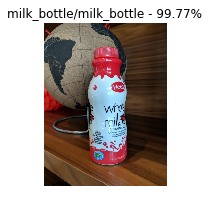

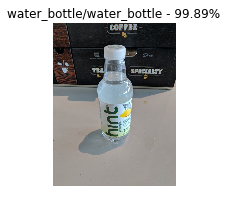

In [21]:
# Plots of the results
actual_labels = ['milk_bottle', 'water_bottle']
for k in range(0, len(result)):
    title = "{}/{} - {}%".format(actual_labels[k], result[k]['label'], 
                                 round(100.*float(result[k]['probability']), 2))
    open_image(images_fname_list[k]).show(title=title)

##### 5b. Via an HTTP request

Deploying a model as a web service creates a REST API. We can then call that API outside of our current workspace and notebook. For that, we need:
- The web service's URL
- One of the authentication keys.

By default, authentication is enabled when deploying models to Azure Kubernetes Service. We can the retrieve both pieces of information easily. 

In [22]:
# Service URL
service_url = aks_service.scoring_uri
print("Send POST requests to: {}".format(service_url))

# Authentication keys
primary, secondary = aks_service.get_keys()
print("Keys to use when calling the service from an external app: {}".format([primary, secondary]))

Send POST requests to: http://104.209.233.179/api/v1/service/aks-image-classif-web-svc/score
Keys to use when calling the service from an external app: ['ymltwgdypOs7Xg7O7oOMtVNLf0cfOwDE', 'HsaS3Dp1tGkpekeS2QnVnBvqlwYLpGgF']


In [23]:
# Send the same test data
if aks_service.state == "Healthy":

    key = aks_service.get_keys()[0]
    # Set the content type
    headers = { 'Content-Type':'application/json' }
    # Set the authorization header
    headers['Authorization']=f'Bearer {key}'
    
    # Send the request
    resp = requests.post(service_url, test_samples, headers=headers)

    print("Predictions: {}".format(resp.text))

Predictions: [{"label": "milk_bottle", "probability": "0.9977195858955383"}, {"label": "water_bottle", "probability": "0.9989380240440369"}]


##### 5c. Using a user interface -- Locally

This notebook is accompanied by 3 files:
- file_uploader.py  <<< REPLACE WITH APPLICATION.PY
- templates/index.html
- templates/template.html

They construct a Flask application that will allow us to test that our service is working as we expect.

We can run this test in 2 different ways:
1. From a terminal window, in our conda environment
2. From within this notebook

###### - From the terminal -
To run the Flask application from our local machine, we need to:
- Copy the 3 files on our machine
- Run `python file_uploader.py 'webservice_url' 'authentication_key'`, where <font color=green>webservice_url</font> and <font color=green>authentication_key</font> should be replaced by the values we obtained above

This returns a URL (typically http :// 127.0.0.1:5000). Clicking on it brings us to a file uploader webpage.

If our service works as expected, after a few seconds, we can see the results presented in a table. CHANGE THE RESULTS WHEN HAVE THOSE WITH NEW DATASET

<img src="screenshots/file_uploader_webpage.jpg" width="500" align="left">
<img src="screenshots/predictions.jpg" width="400" align="center">

> Notes:
- Depending on the size of the uploaded images, the service may or may not provide a response. It is best to send a few small images, i.e. 3-5 images a few kB each.
- The uploader function creates an uploads/ folder in our working directory, which contains the images we uploaded.

###### - From this notebook -
Here, we use a built-in magic command `%run`. The experience is then the same.

To end the test, we just need to hit "Ctrl+C" in the terminal or the "Stop" (square) button in the notebook.

In [24]:
# Built-in magic command to run our Flask application
# Note: "$" in front of our variables names returns their content
%run -i file_uploader.py $service_url $key

 * Serving Flask app "file_uploader" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


Let's click on the url and upload images several times, so we can better see the server's response in the next section.

In [ ]:
# Once we are done, let's not forget to end the test (Ctrl+C or Stop button)

##### 5d. Using a user interface - Online

In [ ]:
>>> ADD SOMETHING ABOUT APP LOGICS HERE

In [ ]:
aks_service.swagger_uri

#### 6. Service telemetry in [Application Insights](https://docs.microsoft.com/en-us/azure/azure-monitor/app/app-insights-overview)

In the [Azure portal](https://portal.azure.com):
- Let's navigate to "All resources"
- Select our subscription and resource group that contain our workspace
- Select the Application Insights type associated with our workspace
  * _If we have several, we can still go back to our workspace (in the portal) and click on "Overview" - This shows the elements associated with our workspace, in particular our Application Insights_
- Click on the App Insights resource: There, we can see a high level dashboard with information on successful and failed requests, server response time and availability
- Click on the "Server requests" graph
- In the "View in Analytics" drop-down, select "Request count" in the "Analytics" section: This displays the specific query ran against the service logs to extract the number of executed requests (successful or not).
- Still in the "Logs" page, click on the eye icon next to "requests" on the "Schema"/left pane, and on "Table" on the right one:
  * This shows the list of calls to the service, with their success statuses, durations, and other metrics. This table is especially useful to investigate problematic requests.
  * Results can also be visualized as a graph by clicking on the "Chart" tab. Metrics are plotted by default, but we can change them by clicking on one of the field name drop-downs.
- Navigate across the different queries we ran through the different "New Query X" tabs.

<img src="screenshots/webservice_performance_metrics.jpg" width="400" align="left">
<img src="screenshots/application_insights_all_charts.jpg" width="500" align="center">

<br><br>
<img src="screenshots/failures_requests_line_chart.jpg" width="500" align="right">
<img src="screenshots/all_requests_line_chart.jpg" width="400" align="left">

<br><br>
<img src="screenshots/logs_failed_request_details.jpg" width="500" align="right">
<img src="screenshots/success_status_bar_chart.jpg" width="450" align="left">



### Clean up

In a real-life scenario, it is likely that the service we created would need to be up and running at all times. However, in the present demonstrative case, and now that we have verified that our service works, we can delete it as well as all the resources we used.

#### Application Insights deactivation

In [ ]:
aks_service.update(enable_app_insights=False)

#### Service termination

In [ ]:
aks_service.delete()

#### Image deletion

In [ ]:
image.delete()